## **IMPORT PACKAGES**

In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import os
#VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## **READING RAW DATA FROM CSV FILE AND SELECTION TO ROUTE AND TIME DESIRED**

We only have taking into account for this project the traffic data for September.

In [73]:
%%time
sourceTest='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/Historico/InputDataTest/09-2018.csv'
df_test=pd.read_csv(sourceTest,sep=';')

CPU times: user 10 s, sys: 2.26 s, total: 12.3 s
Wall time: 12.2 s


In [74]:
df_test.shape

(10668743, 9)

In [75]:
df_test['fecha']=pd.to_datetime(df_test['fecha'], format='%Y-%m-%d %H:%M:%S')

In [76]:
df_test.dtypes

id                              int64
fecha                  datetime64[ns]
tipo_elem                      object
intensidad                    float64
ocupacion                     float64
carga                         float64
vmed                          float64
error                          object
periodo_integracion             int64
dtype: object

Select only the detectors which are involves in our route already defined and for the dates and hour established (7:00AM and for the first week).

In [77]:
route_ids=['6762','6759','6753','6680','6679','6753','6751','6746','6743','6737',
'6736','6732','6729','6727','6725','6724','6720','6717','6715','6714','6713']

In [79]:
df_test_route=df_test.loc[df_test['id'].isin(route_ids)]

In [80]:
df_test_route2=df_test_route.loc[df_test_route['fecha']<=datetime(2018, 9, 8, 7,0,0).date()]

/Users/antoniobravomunoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [136]:
df_test_route_firstweek_7AM = df_test_route2.copy().reset_index(drop=True)

In [137]:
df_test_route_firstweek_7AM.shape

(12313, 9)

In [138]:
df_test_route_firstweek_7AM.dtypes

id                              int64
fecha                  datetime64[ns]
tipo_elem                      object
intensidad                    float64
ocupacion                     float64
carga                         float64
vmed                          float64
error                          object
periodo_integracion             int64
dtype: object

In [140]:
df_test_route_firstweek_7AM.describe()

,id,intensidad,ocupacion,carga,vmed,periodo_integracion
count,12313.000000,12288.000000,10535.000000,12283.000000,12288.000000,12313.000000
mean,6729.889466,2047.763672,7.376080,45.475861,79.130859,14.845123
std,20.423260,1716.357625,7.536129,29.215821,15.661891,0.878117
min,6679.000000,4.000000,1.000000,1.000000,4.000000,1.000000
25%,6717.000000,479.000000,3.000000,17.000000,77.000000,15.000000
50%,6729.000000,1511.500000,6.000000,47.000000,84.000000,15.000000
75%,6746.000000,3392.000000,9.000000,71.000000,88.000000,15.000000
max,6762.000000,7255.000000,99.000000,100.000000,107.000000,15.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a470b5c18>,
      dtype=object)

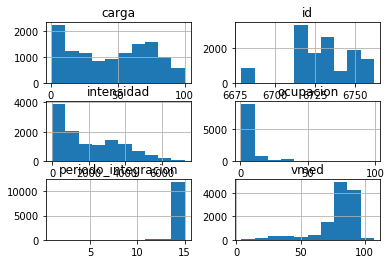

In [141]:
df_test_route_firstweek_7AM.hist()

## **DATA PREPARATION**

**1. Formating "Fecha" Column and splitting it on "Date" and "Hora"**

In [142]:
%%time
df_test_route_firstweek_7AM['Fecha']=df_test_route_firstweek_7AM["fecha"].dt.date
#Creating new columns spiltting Date and Hour of the day.
df_test_route_firstweek_7AM['Hora']=df_test_route_firstweek_7AM["fecha"].dt.time
df_test_route_firstweek_7AM["Date"]=df_test_route_firstweek_7AM["fecha"]
#Drop original column fecha
df_test_route_firstweek_7AM=df_test_route_firstweek_7AM.drop('fecha', 1)

CPU times: user 17 ms, sys: 2.91 ms, total: 19.9 ms
Wall time: 17.6 ms


In [143]:
df_test_route_firstweek_7AM.dtypes

id                              int64
tipo_elem                      object
intensidad                    float64
ocupacion                     float64
carga                         float64
vmed                          float64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
dtype: object

**2. Obtaining X e Y UTM coordinates from others files**

The file has different encoding of the default ones, for doing the load we need to specify the encoding and the decimal number point delimiter.

In [144]:
sourceMP='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/HistoricoPuntosMedidaUbic/pmed_ubicacion_09_2018.csv'
dfplaces=pd.read_csv(sourceMP,sep=';',encoding='ISO-8859-1',decimal=",")

In [145]:
dfplaces.dtypes

tipo_elem     object
id             int64
cod_cent      object
nombre        object
x            float64
y            float64
dtype: object

**3. Transforming Coordinates from UTM to Latitude and Longitude.**

Code function source: https://stackoverflow.com/questions/343865/how-to-convert-from-utm-to-latlng-in-python-or-javascript

Modifications: 
 - Madrid zone value: 30
 - Values returned like a list of float64

In [146]:
def utmToLatLng(easting, northing, northernHemisphere=True,zone=30):
    #Defining default Madrid zone with the value: 30
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return [latitude, longitude]

In [147]:
%%time
dfplaces['LatLong'] = dfplaces.apply(lambda x: utmToLatLng(x['x'], x['y']), axis=1)

CPU times: user 149 ms, sys: 2.31 ms, total: 152 ms
Wall time: 150 ms


In [148]:
%%time
dfplaces[['Lat','Long']] = pd.DataFrame(dfplaces.LatLong.values.tolist(), index= dfplaces.index)

CPU times: user 3.06 ms, sys: 929 µs, total: 3.99 ms
Wall time: 3.13 ms


In [149]:
dfplaces=dfplaces.drop(columns=['LatLong'])

In [150]:
dfplaces.head()

,tipo_elem,id,cod_cent,nombre,x,y,Lat,Long
0,URB,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,40.430502,-3.688323
1,URB,3841,01002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.882340,4.475770e+06,40.430524,-3.687256
2,URB,3842,01003,Pº Recoletos N-S - Almirante-Prim,441319.371258,4.474841e+06,40.422132,-3.691727
3,URB,3843,01004,"Pº Recoletos S-N - Pl, Cibeles- Recoletos",441301.632986,4.474764e+06,40.421433,-3.691929
4,URB,3844,01005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.765072,4.476132e+06,40.433782,-3.688470


**4. Adding Latitude and Longitude to the main dataframe.**

In [151]:
%%time
df_test_route_firstweek_7AM_complete=df_test_route_firstweek_7AM.join(dfplaces.set_index('id')[['Lat','Long']],on='id',how='left',rsuffix='_other')

CPU times: user 8.62 ms, sys: 2.56 ms, total: 11.2 ms
Wall time: 9.27 ms


In [152]:
df_test_route_firstweek_7AM_complete.dtypes

id                              int64
tipo_elem                      object
intensidad                    float64
ocupacion                     float64
carga                         float64
vmed                          float64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
dtype: object

**5. Dealing columns with missing values**

In [153]:
%%time
df_test_route_firstweek_7AM_complete.isnull().any()

CPU times: user 9.94 ms, sys: 2.55 ms, total: 12.5 ms
Wall time: 10.7 ms


id                     False
tipo_elem              False
intensidad              True
ocupacion               True
carga                   True
vmed                    True
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                    False
Long                   False
dtype: bool

In [154]:
nan_rowsIntensidad = df_test_route_firstweek_7AM_complete[df_test_route_firstweek_7AM_complete['intensidad'].isnull()]
nan_rowsOcupac = df_test_route_firstweek_7AM_complete[df_test_route_firstweek_7AM_complete['ocupacion'].isnull()]
nan_rowsCarga = df_test_route_firstweek_7AM_complete[df_test_route_firstweek_7AM_complete['carga'].isnull()]
nan_rowsVmed = df_test_route_firstweek_7AM_complete[df_test_route_firstweek_7AM_complete['vmed'].isnull()]

In [155]:
print("-Number of Nan in Intensidad: {}".format(nan_rowsIntensidad.shape[0]))
print("-Number of Nan in Ocupacion: {}".format(nan_rowsOcupac.shape[0]))
print("-Number of Nan in Carga: {}".format(nan_rowsCarga.shape[0]))
print("-Number of Nan in Vmed: {}".format(nan_rowsVmed.shape[0]))

-Number of Nan in Intensidad: 25
-Number of Nan in Ocupacion: 1778
-Number of Nan in Carga: 30
-Number of Nan in Vmed: 25


In [156]:
df_test_route_firstweek_7AM_complete.shape

(12313, 13)

Dropping Nan values.

In [157]:
%%time
df_test_route_firstweek_7AM_complete=df_test_route_firstweek_7AM_complete.dropna(axis=0)

CPU times: user 10.1 ms, sys: 1.9 ms, total: 12 ms
Wall time: 10.4 ms


In [158]:
df_test_route_firstweek_7AM_complete.shape

(10526, 13)

In [159]:
%%time
df_test_route_firstweek_7AM_complete.isnull().any()

CPU times: user 7.04 ms, sys: 1.91 ms, total: 8.95 ms
Wall time: 6.91 ms


id                     False
tipo_elem              False
intensidad             False
ocupacion              False
carga                  False
vmed                   False
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                    False
Long                   False
dtype: bool

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1abd5ff400>,
      dtype=object)

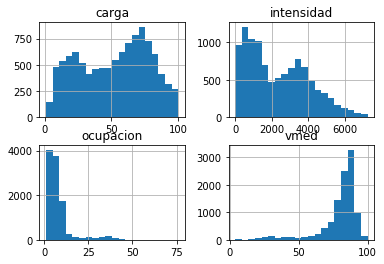

In [160]:
df_test_route_firstweek_7AM_complete[['intensidad','ocupacion','vmed','carga']].hist(bins=20)

**6. Homogenizing values that are different because come from different files.**

An example of this is that feature 'tipo_elem' contains different names from one files to anothers. To homogenize this feature, we apply a function to map it in a uniform way.

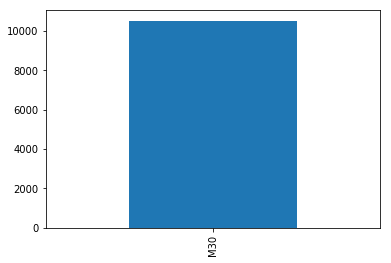

In [161]:
# Before applying the function. Histograms based on the categories.
df_test_route_firstweek_7AM_complete['tipo_elem'].value_counts().plot(kind='bar')

In this case, we only have a value in opposition of train set.

**7. Dealing with wrong values**

In this case, we dont have anomalous values for the features.

In [162]:
df_test_route_firstweek_7AM_complete.describe()

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Lat,Long
count,10526.000000,10526.000000,10526.000000,10526.000000,10526.000000,10526.000000,10526.000000,10526.000000
mean,6729.556907,2351.216797,7.346855,52.075052,79.530401,14.909082,40.432354,-3.667283
std,20.665193,1671.041131,7.427167,26.233732,14.767808,0.748585,0.030781,0.007450
min,6679.000000,5.000000,1.000000,1.000000,4.000000,1.000000,40.383376,-3.683001
25%,6717.000000,892.000000,3.000000,28.000000,77.000000,15.000000,40.407452,-3.673634
50%,6729.000000,2054.500000,6.000000,56.000000,84.000000,15.000000,40.435325,-3.665770
75%,6746.000000,3596.000000,9.000000,74.000000,88.000000,15.000000,40.461982,-3.660087
max,6762.000000,7255.000000,76.000000,100.000000,100.000000,15.000000,40.481905,-3.659082


**8. Looking for Outliers**

In test case, we shouldn't remove outliers avoiding to have influence in the test results. 

**9. One Hot Encoding for categorical features**

We have 2 categorical features: *"Tipo_elem"* and *"error"*

In [163]:
%%time
df_test_route_firstweek_7AM_complete1=pd.get_dummies(df_test_route_firstweek_7AM_complete['tipo_elem'])
df_test_route_firstweek_7AM_complete2=pd.get_dummies(df_test_route_firstweek_7AM_complete['error'])

CPU times: user 4.24 ms, sys: 1.65 ms, total: 5.89 ms
Wall time: 4.24 ms


In [164]:
%time
df_test_route_firstweek_7AM_complete3=df_test_route_firstweek_7AM_complete.merge(df_test_route_firstweek_7AM_complete1,left_index=True,right_index=True)
df_test_route_firstweek_7AM_complete3=df_test_route_firstweek_7AM_complete3.merge(df_test_route_firstweek_7AM_complete2,left_index=True,right_index=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [165]:
df_test_route_firstweek_7AM_complete3.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,Fecha,Hora,Date,Lat,Long,M30,N
0,6679,M30,2468.0,3.0,38.0,87.0,N,15,2018-09-01,00:00:00,2018-09-01 00:00:00,40.393663,-3.674823,1,1
1,6679,M30,2488.0,4.0,37.0,87.0,N,15,2018-09-01,00:15:00,2018-09-01 00:15:00,40.393663,-3.674823,1,1
2,6679,M30,2503.0,4.0,38.0,88.0,N,15,2018-09-01,00:30:00,2018-09-01 00:30:00,40.393663,-3.674823,1,1
3,6679,M30,2140.0,3.0,32.0,88.0,N,15,2018-09-01,00:45:00,2018-09-01 00:45:00,40.393663,-3.674823,1,1
4,6679,M30,2156.0,4.0,33.0,90.0,N,15,2018-09-01,01:00:00,2018-09-01 01:00:00,40.393663,-3.674823,1,1


In [166]:
df_test_route_firstweek_7AM_complete3.dtypes

id                              int64
tipo_elem                      object
intensidad                    float64
ocupacion                     float64
carga                         float64
vmed                          float64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
M30                             uint8
N                               uint8
dtype: object

-------------

## **BREAK TO SAVE DATA FOR VISUALIZATIONS**

-------------

**10. Splitting and adapting *"Date"* feature in separated fields in order to adecuate data to Machine Learning Algorithm**

In [167]:
%%time
#Parsing Date feature to string in order to split it
df_test_route_firstweek_7AM_complete3['Date'] = df_test_route_firstweek_7AM_complete3['Date'].astype(str)

CPU times: user 17.6 ms, sys: 1.72 ms, total: 19.3 ms
Wall time: 17.8 ms


In [168]:
type(df_test_route_firstweek_7AM_complete3['Date'][0])

str

In [169]:
%%time
df_test_route_firstweek_7AM_complete3['FechaAUX'], df_test_route_firstweek_7AM_complete3['HoraAUX'] = df_test_route_firstweek_7AM_complete3['Date'].str.split(' ', 1).str
df_test_route_firstweek_7AM_complete3['Anio'], df_test_route_firstweek_7AM_complete3['Mes'], df_test_route_firstweek_7AM_complete3['Dia'] = df_test_route_firstweek_7AM_complete3['FechaAUX'].str.split('-', 2).str
df_test_route_firstweek_7AM_complete3['Hora'], df_test_route_firstweek_7AM_complete3['Minutos'], df_test_route_firstweek_7AM_complete3['Segundos']= df_test_route_firstweek_7AM_complete3['HoraAUX'].str.split(':', 2).str

CPU times: user 186 ms, sys: 4.59 ms, total: 190 ms
Wall time: 190 ms


Dropping unusable and auxiliar columns including "Segundos" due to its value is always 00.

In [170]:
df_test_route_firstweek_7AM_complete3=df_test_route_firstweek_7AM_complete3.drop(['FechaAUX','HoraAUX','Date','Segundos'],axis=1)

Casting to integer for generated columns

In [171]:
df_test_route_firstweek_7AM_complete3 = df_test_route_firstweek_7AM_complete3.astype({"Anio": int, "Mes": int, "Dia": int, "Hora": int, "Minutos": int})

In [172]:
df_test_route_firstweek_7AM_complete3.dtypes

id                       int64
tipo_elem               object
intensidad             float64
ocupacion              float64
carga                  float64
vmed                   float64
error                   object
periodo_integracion      int64
Fecha                   object
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
N                        uint8
Anio                     int64
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

**11. Cleaning-up the complete dataframe (Dropping auxiliar columns, original columns encoded, etc)**

Dropping columns without information in our dataset because it has a constant value for all rows.
These are "error" an "Anio". "Error" has always N value and for this case we only have data for 2018, so Anio is constant.

In [174]:
df_test_route_firstweek_7AM_complete4=df_test_route_firstweek_7AM_complete3.drop(columns=['N','Anio'])

In [175]:
df_test_route_firstweek_7AM_complete4.dtypes

id                       int64
tipo_elem               object
intensidad             float64
ocupacion              float64
carga                  float64
vmed                   float64
error                   object
periodo_integracion      int64
Fecha                   object
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

Dropping irrelevant columns for modeling

In [177]:
df_test_route_firstweek_7AM_final=df_test_route_firstweek_7AM_complete4.drop(columns=['tipo_elem','error','Fecha'])

In [193]:
df_test_route_firstweek_7AM_final.dtypes

id                       int64
intensidad             float64
ocupacion              float64
carga                  float64
vmed                   float64
periodo_integracion      int64
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

In [194]:
df_test_route_firstweek_7AM_final.insert(10, 'URB', 0)

In [195]:
df_test_route_firstweek_7AM_final.dtypes

id                       int64
intensidad             float64
ocupacion              float64
carga                  float64
vmed                   float64
periodo_integracion      int64
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
URB                      int64
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

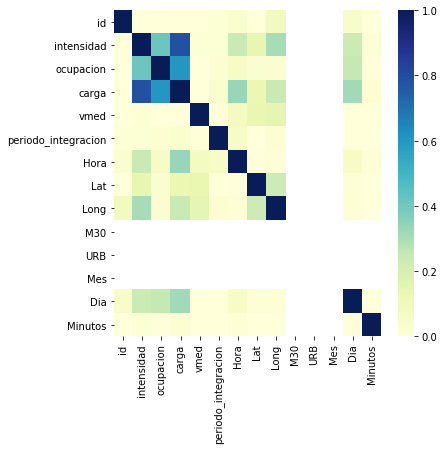

In [196]:
plt.figure(figsize=(6,6))
sns.heatmap(df_test_route_firstweek_7AM_final.corr(),vmin=0,vmax=1,cmap="YlGnBu")

## **SAVING FINAL DATA**

Saving complete processed traffic data

In [197]:
%%time
df_test_route_firstweek_7AM_final.to_csv('/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data-Science-Master-project/DATA/traffic_data_test_complete.csv',index=False)

CPU times: user 162 ms, sys: 13.7 ms, total: 176 ms
Wall time: 175 ms


For the final test dataset we see that not all detectors have the same registers. This is a real situation, so we are not going to do anything. We will predict the carga values over using these data.

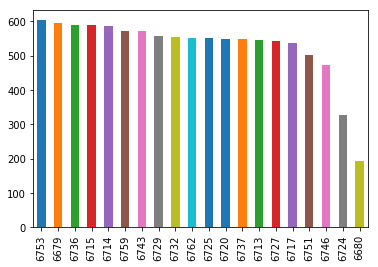

In [198]:
df_test_route_firstweek_7AM_final['id'].value_counts().plot(kind='bar')